In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.template_match_target import *
import cv2
import glob
import os
import h5py
import pandas as pd
%matplotlib inline

dim=256

def get_id(i, zeropad=5):
    return 'img_{i:0{zp}d}'.format(i=i, zp=zeropad)

/Users/silburt/anaconda2/envs/plotting/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [26]:
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/m/mhvk/czhu/moondata/final_data/ /Users/silburt/remotemount/")
dirssh = '/Users/silburt/remotemount'
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/r/rein/silburt/moon-craters/datasets/HEAD/ /Users/silburt/remotemount2/")
dirssh2 = '/Users/silburt/remotemount2'
dim=256

## MOON

In [3]:
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/m/mhvk/czhu/moondata/newscripttest_for_ari/ /Users/silburt/remotemount3/")
dirssh3 = '/Users/silburt/remotemount3'

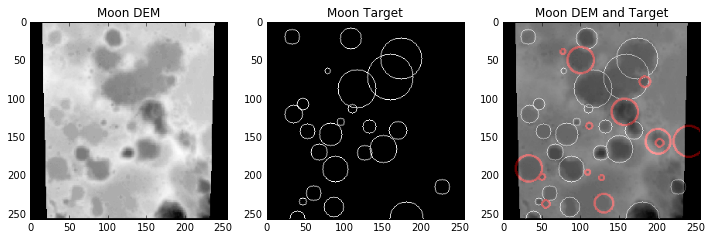

In [7]:
dtype = 'dev'
imgs = h5py.File('%s/%s_images.hdf5'%(dirssh3,dtype), 'r')
craters = pd.HDFStore('%s/%s_craters.hdf5'%(dirssh3,dtype),'r')
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[12, 4])

#(dev,3) - many false negatives
i=3

img = imgs['input_images'][i]
img = img/255.
low,hi=0.01,1
minn, maxx = np.min(img[img>0]), np.max(img[img>0])
img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling

csv = craters[get_id(i)]
csv = np.asarray((csv['x'],csv['y'],csv['Diameter (pix)']/2)).T
cimg = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2BGR) 
for c in csv:
    x,y,r = c
    cv2.circle(cimg,(int(x),int(y)),int(r),(255,255,255),thickness=1)

ax2.imshow(cimg, origin='upper')
    
#(dev,3)
missed_coords = [(100,50,17),(157,117,17),(33,190,17),(50,201,4),(200,155,16),
                 (202,157,5),(77,39,3),(240,155,20),(109,195,3),(183,78,7),
                 (111,135,4),(130,235,12),(127,202,3),(55,236,5)]
for c in missed_coords:
    x,y,r = c
    cv2.circle(cimg,(int(x),int(y)),int(r),(255,0,0),thickness=2)
    
ax1.imshow(img.reshape(dim,dim),origin='upper', cmap="Greys_r")
ax3.imshow(img.reshape(dim,dim),origin='upper', cmap="Greys_r")
ax3.imshow(cimg,origin='upper', alpha=0.4)

ax1.set_title('Moon DEM')
ax2.set_title('Moon Target')
ax3.set_title('Moon DEM and Target')
plt.savefig('images/paper_images/paper_DataTargetOverlap_Moon.png')

### Pred Comparison

In [11]:
dtype = 'dev'
imgs = h5py.File('%s/%s_images.hdf5'%(dirssh,dtype), 'r')
craters = pd.HDFStore('%s/%s_craters.hdf5'%(dirssh,dtype),'r')
preds = h5py.File('%s/HEAD_%spreds_n30000_final.hdf5'%(dirssh2,dtype), 'r')[dtype]

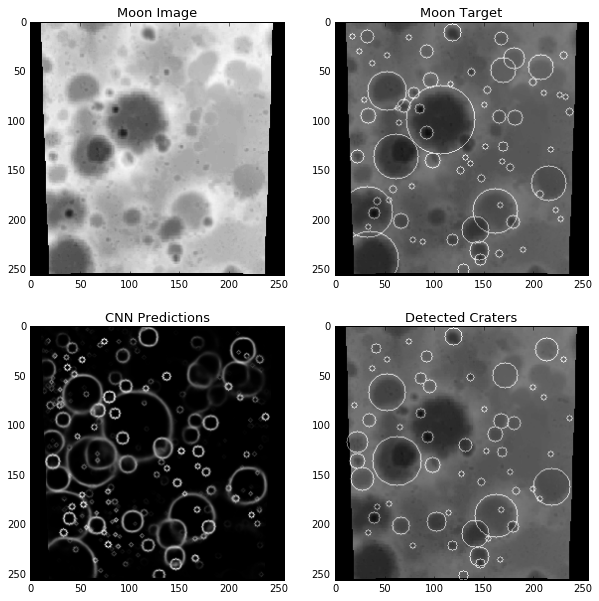

In [7]:
i = 15
coords = template_match_t(preds[i].copy(), minrad=3)

mask = np.zeros((dim,dim))
radii_dist = []
for c in coords:
    x,y,r = c
    cv2.circle(mask, (x,y), r, 1, 1)
    radii_dist.append(r)
    
img = imgs['input_images'][i]
img = img/255.
low,hi=0.1,1
minn, maxx = np.min(img[img>0]), np.max(img[img>0])
img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling

target = imgs['target_masks'][i]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=[10, 10])
ax1.imshow(img.reshape(dim,dim), origin='upper', cmap="Greys_r")
ax2.imshow(img.reshape(dim,dim), origin='upper', cmap="Greys_r")
ax2.imshow(target.reshape(dim,dim), origin='upper', cmap="Greys_r",alpha=0.5)
ax3.imshow(preds[i].reshape(dim,dim), origin='upper', cmap="Greys_r")
ax4.imshow(img.reshape(dim,dim), origin='upper', cmap="Greys_r")
ax4.imshow(mask, origin='upper', cmap="Greys_r",alpha=0.5)

fontsize=13
ax1.set_title('Moon Image',fontsize=fontsize)
ax2.set_title('Moon Target',fontsize=fontsize)
ax3.set_title('CNN Predictions',fontsize=fontsize)
ax4.set_title('Detected Craters',fontsize=fontsize)
plt.savefig('images/paper_DataTargetPredExtract_Moon.png')
#ax5.hist(radii_dist, 10)

# MERCURY

In [2]:
# load data
data = np.load('catalogues/mercury/merc_0_input_charles.npy')
#data = np.load('catalogues/mercury/merc_input.npy')
data = data.reshape(len(data),256,256,1)/255.
#target = np.load('catalogues/mercury/merc_0_targets_charles.npy')
for img in data:
    #img[img > 0.] = 1. - img[img > 0.]   #inv color
    minn, maxx = np.min(img[img>0]), np.max(img[img>0])
    low, hi = 0.1, 1                                                #low, hi rescaling values
    img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling

In [3]:
# load preds - old preds or predict on the fly
preds = np.load('catalogues/mercury/merc_0_input_charles_modelpreds_n10_new.npy')
#preds = np.load('catalogues/mercury/merc_preds.npy')

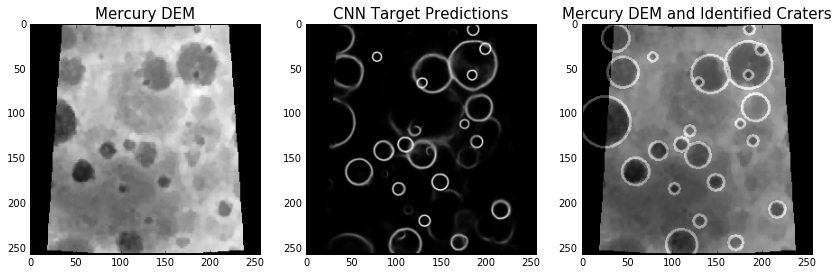

In [7]:
# extract coords for i
i=7

coords = template_match_t(preds[i].copy())
mask = np.zeros((dim,dim))
for c in coords:
    x,y,r = c
    cv2.circle(mask, (x,y), r, 1, 2)

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[14, 6])
img = data[i].reshape(256,256)

ax1.imshow(img,origin='upper', cmap="Greys_r")
ax2.imshow(preds[i],origin='upper', cmap="Greys_r")
ax3.imshow(img,origin='upper', cmap="Greys_r")
ax3.imshow(mask,origin='upper', cmap="Greys_r",alpha=0.3)

fontsize=15
ax1.set_title("Mercury DEM",fontsize=fontsize)
ax2.set_title("CNN Target Predictions",fontsize=fontsize)
ax3.set_title("Mercury DEM and Identified Craters",fontsize=fontsize)
plt.savefig("images/paper_images/paper_DataPredOverlap_Mercury.pdf")
#plt.savefig("images/FP_TP_Classification/mercury/%d.png"%i)